# Code Snippet 1

Description: Code used to extract the data of the LAION-400M parquet files. 

link: https://www.kaggle.com/datasets/romainbeaumont/laion400m

In [1]:
import pandas as pd

def LoadLAION_400MImages(parquet_file_paths, labels):
    """ 
    Description:
    This function is used to retrieve the image from the LAION-400M parquet files retrieved from Kaggle.
    
    Parameters:
    parquet_file_paths (list) - List containing the parquet file paths.
    labels (list) - List containing the labels to query the images.

    Returns:
    img_url_dict (dict) - Dict containing the text and urls of the relevant images.
    """
    img_url_dict = {new_list: [] for new_list in labels}
    
    for parquet_file_path in parquet_file_paths:
        # Reading the contents of the parquet file
        df = pd.read_parquet(parquet_file_path)

        # Looping through the dataframe
        for index in range(len(df)):
            # Removing any NSFW images
            if df["NSFW"][index] != "NSFW":
                # Looping through the labels
                for label in labels:
                        # Checking if the label is in the text
                        if df['TEXT'][index] != None and label.lower() in df['TEXT'][index].lower().split():   
                            img_url_dict[label].append({"text": df["TEXT"][index], "url":df['URL'][index]})
            
    return img_url_dict

# Code Snippet 2

Description: Code used to access links and retrieve their associated images.

In [2]:
from tqdm import tqdm
import urllib.request
from matplotlib import pyplot as plt
import numpy as np

def RetrieveImagesFromLinks(listOfImageLinks):
    """ 
    Description:
    This function is used to retrieve images from the links.
    
    Parameters:
    listOfImageLinks (list) - List containing the image links to retrieve.

    Returns:
    images (list) - List containing the retrieved images.
    failedToGetImageCounter (int) - Counter keeping track of how many images were not retrieved.
    """

    images = []
    
    # Progress bar used to keep track of process execution
    progress_bar = tqdm(total=len(listOfImageLinks), desc="Processing", unit="links")
    
    # Counter used to keep track of how many images were not retrieved
    failedToGetImageCounter = 0
    
    for img_url in listOfImageLinks:
        try:
            # timeout added in case image takes too long to retrive from link 
            image_data = urllib.request.urlopen(img_url['url'], timeout=10)
            
            # Converting the image to .jpg
            img = plt.imread(image_data, format='jpg')
            
            # Checking that the image is of the correct type
            if img.dtype != np.uint8:
                # Fixing images of type float32
                if img.dtype == np.float32:
                    img = (img * 255).astype(np.uint8)
            
            # Adding the image to images list
            images.append(img)
        except Exception as error:
            failedToGetImageCounter+=1
        
        # Updating the progress bar
        progress_bar.update(1)
    
    return images, failedToGetImageCounter

# Code Snippet 3
Description: Code used to filter out images which contain no people.

In [3]:
from ultralytics import YOLO

def RemoveImageNotContainingPeople(images, confidence_threshold=0.5):
    """ 
    Description:
    This function serves to remove images which don't contain people within them.
    
    Parameters:
    model - YOLO model used to detect the person in the image.
    images (list) - List containing the images to be processed.
    confidence_threshold (float) - Confidence threshold to filter out predictions below the threshold.

    Returns:
    filtered_images (list) - List containing the filtered images.
    """
    
    filtered_images = []
    model = YOLO('yolov8n.pt')

    for input_image in images:
        
        try:
            # Making predictions
            predictions = model.predict(input_image, classes=0)
            
            for index, i in enumerate(predictions[0].boxes.cls):
                # Checking if the image contains a person and if the confidence is above the threshold
                if i == 0 and predictions[0].boxes.conf[index] > confidence_threshold: 
                    filtered_images.append(input_image)
                    break
        except:
            continue

    return filtered_images

In [9]:
import cv2
import os

parquet_file_paths = ["..\\Datasets\\LAION-400M\\part-00001-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet"]
labels = ["doctor", "nurse"]

url_dict_1 = LoadLAION_400MImages(parquet_file_paths, labels)
docImages, docFailedToGetImageCounter = RetrieveImagesFromLinks(url_dict_1["doctor"])

confidence_threshold = 0.75
filtered_images = RemoveImageNotContainingPeople(docImages, confidence_threshold)

# Folder needs to be created manually before images can be saved
directory_path = "..\\DownloadedImages\\LAION-400M\\doctorImageLAION400M-1"
for index, image in enumerate(filtered_images):
    cv2.imwrite(os.path.join(directory_path, str(index)+".jpg"), cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Code Snippet 4
Description: Code used to move a random number of images from one directory to another.
 
Note: This was used to select the 385 images from the LAION-400M dataset.

In [11]:
import os
import shutil
import random

def move_random_images(source_dir, destination_dir, num_images_to_move):
    """ 
    Description:
    This function moves a randomly selected number of images from one directory to another, primarily used for random image selection.

    Parameters:
    source_dir (str) - The directory containing the images to move
    destination_dir (str) - The directory to move the images to
    num_images_to_move (int) - The number of images to move

    Returns:
    None
    """

    # Get a list of all files in the source directory
    all_images = [f for f in os.listdir(source_dir) if f.endswith('.jpg') or f.endswith('.png')]

    # Randomly select the specified number of images
    selected_images = random.sample(all_images, min(num_images_to_move, len(all_images)))

    # Move the selected images to the destination directory
    for image in selected_images:
        source_path = os.path.join(source_dir, image)
        destination_path = os.path.join(destination_dir, image)
        shutil.move(source_path, destination_path)
        print(f'Moved: {image}')

# Replace these paths with your actual source and destination directories
source_directory = '..\\DownloadedImages\\LAION-400M\\doctorImagesFiltered'
destination_directory = '..\\DownloadedImages\\LAION-400M\\doctorImageSubsetsForProcessing\\tmp'

# Specify the number of images you want to move
num_images_to_move = 385

# Call the function to move random images
move_random_images(source_directory, destination_directory, num_images_to_move)

# Code Snippet 5
Description: Code used to determine which images have only a specified number of people in them and copy those images to another directory.

Note: This was used to select the 97 images used for the Google Form.

In [16]:
import os
import dlib
import cv2
from ultralytics import YOLO
import torch
import random

def get_person_images(source_dir, destination_dir, confidence_threshold, number_of_people, num_images_to_move = None):
    """ 
    Description:
    This function moves all or a randomly selected number of images containing the indicated number of people from one directory to another.

    Parameters:
    source_dir (str) - The directory containing the images to move
    destination_dir (str) - The directory to move the images to
    confidence_threshold (float) - The confidence threshold for the YOLO model
    number_of_people (int) - The number of people to look for in the images
    num_images_to_move (int) - The number of images to move

    Returns:
    None
    """
    
    # Get a list of all files in the source directory
    all_images = [f for f in os.listdir(source_directory) if f.endswith('.jpg') or f.endswith('.png')]

    # Loading the YOLO model. This is downloaded automatically when run for the first time.
    model = YOLO('yolov8n.pt')

    # List to store the images containing the specified number of people
    person_images = []

    # Loop through all images in the source directory
    for image in all_images:
        # Loading the image
        input_image_path = os.path.join(source_dir, image)
        image = dlib.load_rgb_image(input_image_path)

        # Making predictions
        predictions = model.predict(image, classes=0)
        scores = predictions[0].boxes.conf

        # Filtering out the predictions based on the confidence threshold
        filtered_indices = torch.where(scores > confidence_threshold)[0]
        if len(filtered_indices) == number_of_people:
            person_images.append(image) 

    # Randomly select the specified number of images
    selected_images = person_images if num_images_to_move == None else random.sample(person_images, min(num_images_to_move, len(person_images)))

    # Copying the images over to the new directory
    for imgIndex, image in enumerate(selected_images):
        save_path = destination_dir
        save_path = os.path.join(save_path,str(imgIndex)+".jpg")
        cv2.imwrite(save_path, cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

source_directory = '..\\MidJourney\\DoctorFinalisedFiltering'   
destination_directory = '..\\MidJourney\\tmp' 
confidence_threshold = 0.5
number_of_people = 1
num_images = 10

get_person_images(source_directory, destination_directory, confidence_threshold, number_of_people, num_images_to_move = num_images)

# Code Snippet 6

Description: Code used to load and process the data retrieved from the Google Forms

{'Gender': {'Male': 7, 'Female': 6}, 'Nationality': {'Malta': 13}, 'Age': {17: 1, 19: 1, 20: 2, 22: 2, 30: 1, 46: 2, 48: 1, 49: 1, 50: 1, 55: 1}}
{'Gender': {'Male': 7, 'Female': 9}, 'Nationality': {'Malta': 16}, 'Age': {17: 1, 19: 1, 20: 2, 22: 1, 29: 1, 33: 1, 37: 1, 38: 1, 41: 1, 46: 1, 49: 1, 50: 1, 53: 2, 57: 1}}


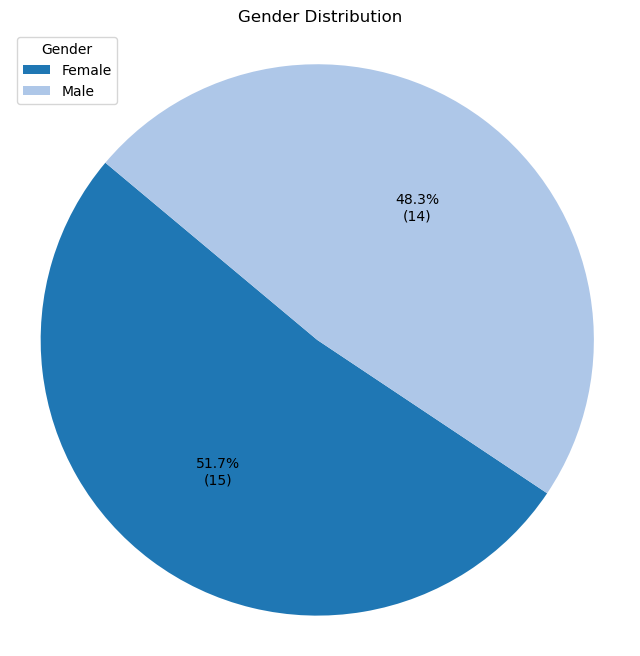

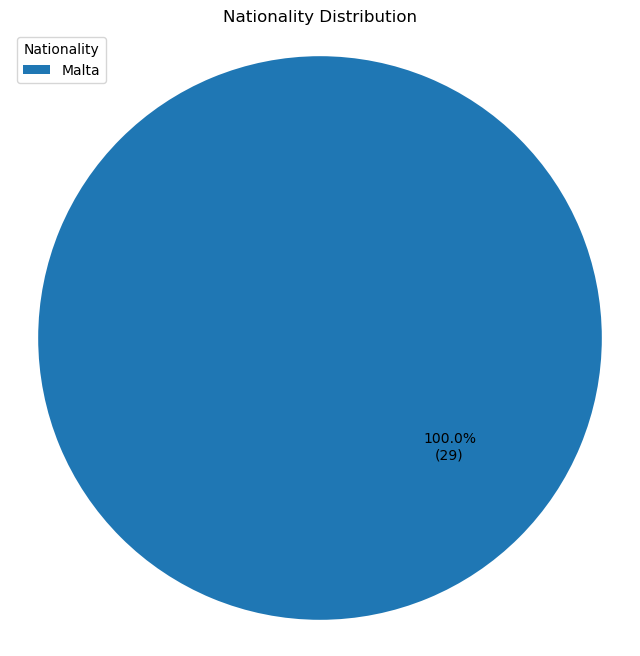

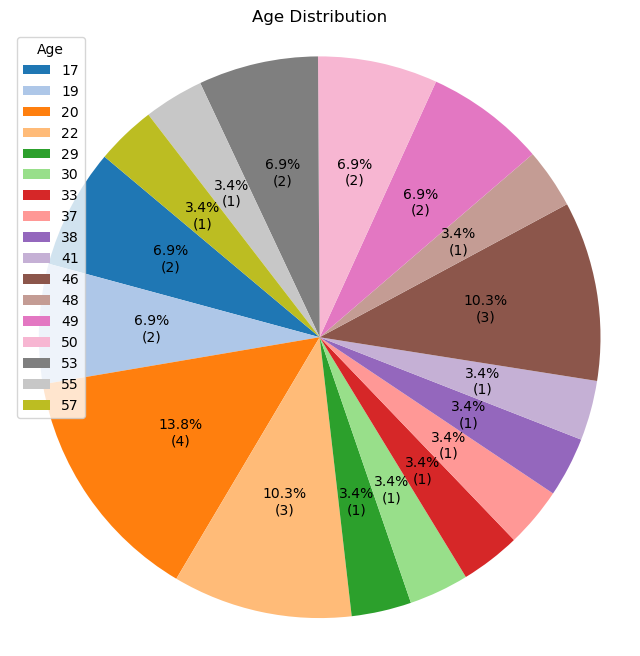

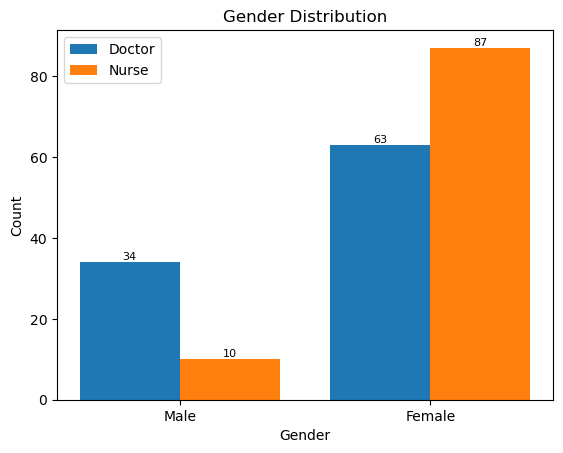

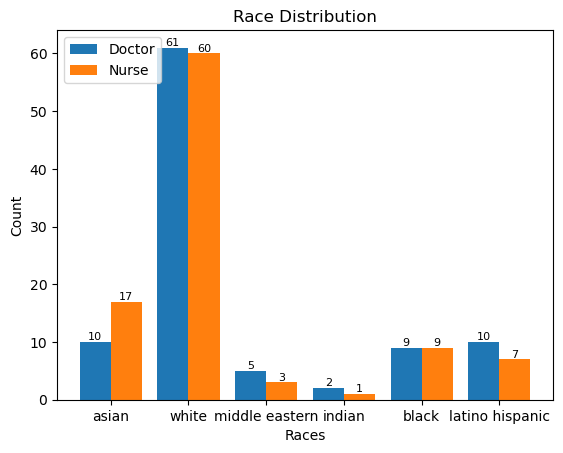

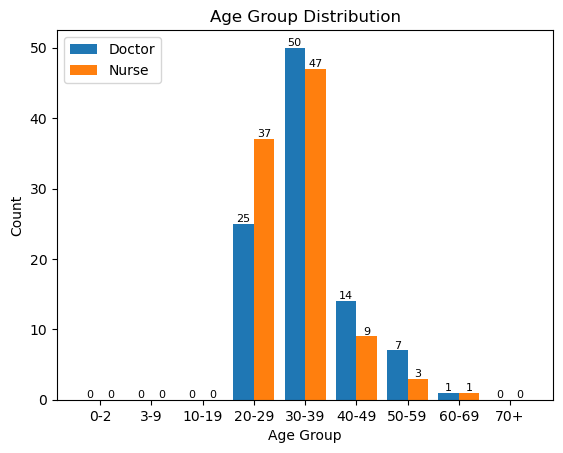

In [142]:
# Note: The NAN values in the CSV file are present as those images were annotated by other users. 
# For instance image 0 was annoted by user 1 & 2 but image 25 was annoted by users 3 & 4 so 
# image 0 has NaN values for user 3 & 4 and image 25 has NaN values for user 1 & 2.

import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

# List of files containing the annotations
doctor_file_paths = ["..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 1 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 2 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 3 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 4 (Responses) - Form responses 1.csv"]

# List of files containing the annotations
nurse_file_paths = ["..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 1 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 2 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 3 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 4 (Responses) - Form responses 1.csv"]

def LoadAndProcessGoogleFormData(file_paths):
    """ 
    Description:
    This function loads the google form csv files, updates their column names and assigns a singular 
    result per attribute per image entry based on the most common value/averaging.
    
    Parameters:
    file_paths (list) - List containing the distance between the centers of the image and the center of the bounding box in each image.

    Returns:
    image_set_data (dict) - Dictionary containing the processed data for each image.
    """

    # Initialize an empty DataFrame to store the concatenated data
    df = pd.DataFrame()

    # Dictionary to store the image data
    image_set_data = {}
    user_set_data = {"Gender":{}, "Nationality":{}, "Age":{}}

    # Loop through each CSV file and concatenate the DataFrames
    for index, csv_file in enumerate(file_paths):
        # Read a singular CSV file into a DataFrame
        part_df = pd.read_csv(csv_file)

        # Changing the column names for easier access
        # List of column names
        column_names = part_df.keys()

        column_mapping = {}
        column_mapping[column_names[1]] = "Gender_User"
        column_mapping[column_names[2]] = "Nationality_User"
        column_mapping[column_names[3]] = "Age_User"
        
        # Each file contains 25 images, so the image number is calculated by multiplying the index by 25
        image_number = index*25

        # Loop through the column names, starting from the 5th column and update the names accroding to the image with which the coencide
        for index in range(4,len(column_names),3):
            column_mapping[column_names[index]] = "Gender_"+str(image_number)
            column_mapping[column_names[index+1]] = "Race_"+str(image_number)
            column_mapping[column_names[index+2]] = "Age_"+str(image_number)
            image_number += 1

        # Rename the columns using the rename method
        part_df = part_df.rename(columns=column_mapping)
        df = pd.concat([df, part_df], ignore_index=True)

    # Loop through the DataFrame and retrieve the user data
    for _, row in df.iterrows():
        for label in ["Gender", "Nationality", "Age"]:
            entry = row[label+"_User"]
            if entry not in user_set_data[label]:
                user_set_data[label][entry] = 1
            else:
                user_set_data[label][entry] += 1
    user_set_data["Age"] = dict(sorted(user_set_data["Age"].items()))

    # The number of images is calculated by subtracting 4 (Timestamp/Gender_User/Race_User/Age_User) 
    # from the total number of columns and then dividing by 3 (Number of labels for each image)
    number_of_images = int((len(df.keys())-4)/3)
    for image_index in range(0,number_of_images):
        image_data = {}
        image_data["age"] = list(df["Age_"+str(image_index)].dropna())
        image_data["gender"] = list(df["Gender_"+str(image_index)].dropna())
        image_data["race"] = list(df["Race_"+str(image_index)].dropna())
        image_set_data[image_index] = image_data

    for image_index in image_set_data:
        age = round(np.mean(image_set_data[image_index]["age"]))

        if age >= 0 and age <= 2: 
            age_label = "0-2"
        elif age >= 3 and age <= 9:
            age_label = "3-9"
        elif age >= 10 and age <= 19:
            age_label = "10-19"
        elif age >= 20 and age <= 29:
            age_label = "20-29"
        elif age >= 30 and age <= 39:
            age_label = "30-39"
        elif age >= 40 and age <= 49:
            age_label = "40-49"
        elif age >= 50 and age <= 59:
            age_label = "50-59"
        elif age >= 60 and age <= 69:
            age_label = "60-69"
        elif age >= 70:
            age_label = "70+"
        
        image_set_data[image_index]["age"] = age_label
        # Takes the most common value otherwise the first value
        image_set_data[image_index]["gender"] = Counter(image_set_data[image_index]["gender"]).most_common(1)[0][0] 
        image_set_data[image_index]["race"] = Counter(image_set_data[image_index]["race"]).most_common(1)[0][0]

    return user_set_data, image_set_data

def DisplayGoogleFormData(image_set_data):
    """ 
    Description:
    This Function displays the label counts across all images.
    
    Parameters:
    image_set_data (dict) - Dictionary containing the processed data for each image.

    Returns:
    None.
    """
    
    # Initialize the count dictionaries
    gender_count = {"male":0,"female":0}
    race_count = {"white":0,"black":0,"latino hispanic":0,"asian":0,"indian":0,"middle eastern":0}
    age_count = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}

    # Loop through the image set data and update the mappings
    for index in image_set_data: 
        age_count[image_set_data[index]["age"]] += 1
        gender_count[image_set_data[index]["gender"].lower()] += 1
        race_count[image_set_data[index]["race"].lower()] += 1

    # Plotting gender data
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    bars = plt.bar(gender_count.keys(), gender_count.values())
    values = gender_count.values()
    plt.title('Gender Distribution')
    plt.xlabel('Gender')
    plt.ylabel('Count')
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, str(value), ha='center', va='bottom')

    # Plotting race data
    plt.subplot(1, 3, 2)
    bars = plt.bar(race_count.keys(), race_count.values())
    values = race_count.values()
    plt.title('Race Distribution')
    plt.xlabel('Race')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, str(value), ha='center', va='bottom')

    # Plotting age data
    plt.subplot(1, 3, 3)
    bars = plt.bar(age_count.keys(), age_count.values())
    values = age_count.values()
    plt.title('Age Distribution')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def MultiMetricGenderDisplay(datasets, specific_race=None, specific_emotion=None, specific_age=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the gender metrics in relation to the FairFace data passed. 
    
    Parameters:
    datasets (list of dicts) - List containing dictionaries containing the information relevant to each image.
    specific_race (str) - Specific race to be considered, if any. Valid values ["white", "black", "latino hispanic", "asian", "indian", "middle eastern"]
    specific_age (int) - Specific age to be considered, if any. Valid values ["0-2","3-9","10-19","20-29","30-39","40-49","50-59","60-69","70+"]

    Returns:
    None.
    """
        
    num_datasets = len(datasets)
    bar_width = 0.8 / num_datasets  # Adjust the denominator to control the spacing between groups
    
    for idx, data in enumerate(datasets):
        # Gender labels - assumes only two genders
        genders = ['Male', 'Female']
        count = [0, 0]

        # Looping through the instances in the data
        for instance in datasets[data]:

            # Enforcing race constraints 
            if specific_race is not None:
                if datasets[data][instance]["race"].lower() != specific_race.lower():
                    continue

            # Enforcing age constraints 
            if specific_age is not None:
                if datasets[data][instance]["age"] != specific_age:
                    continue

            # Retrieving instance gender
            mGender = datasets[data][instance]["gender"].lower()

            # Incrementing counters
            if mGender == "male" or mGender == "man":
                count[0] += 1
            elif mGender == "female" or mGender == "woman":
                count[1] += 1
            else:
                print("Invalid Gender Detected: ", mGender)

        # Calculate the positions of bars for current dataset
        positions = [i + (idx * bar_width) for i in range(len(genders))]
        
        # Creating bar chart with different color for each dataset
        plt.bar(positions, count, bar_width, label=data)

        # Adding annotations with values above each bar
        for i, value in zip(positions, count):
            # Add text label at calculated position
            plt.text(i, value, str(value), ha='center', va='bottom', fontsize=8)

    # Adjust x-axis ticks and labels
    plt.xticks([i + ((num_datasets - 1) * bar_width) / 2 for i in range(len(genders))], genders)

    # Adding labels and title
    plt.xlabel('Gender')
    plt.ylabel('Count')
    plt.title('Gender Distribution')

    # Adding legend
    plt.legend(loc='upper left')

    # Showing the plot
    plt.show()

def MultiMetricRaceDisplay(datasets, specific_gender=None, specific_emotion=None, specific_age=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the race metrics in relation to the DeepFace data passed. 
    
    Parameters:
    datasets (list of dicts) - List containing dictionaries containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]
    specific_age (int) - Specific age to be considered, if any.

    Returns:
    None.
    """
    
    # Determine bar width and index offset based on number of datasets
    num_datasets = len(datasets)
    bar_width = 0.8 / num_datasets  # Adjusted for the number of datasets
    index_offset = -(0.4 - bar_width / 2)

    # Loop through datasets
    for idx, data in enumerate(datasets):
        # Race labels - assumes races detected by DeepFace
        races = ["asian", "white", "middle eastern", "indian", "black", "latino hispanic"]
        count = [0] * len(races) 

        # Looping through the instances in the data
        for instance in datasets[data]:
            # Enforcing gender constraints 
            if specific_gender is not None:
                if datasets[data][instance]["gender"].lower() != specific_gender.lower():
                    continue
            # Enforcing age constraints         
            if specific_age is not None:
                if datasets[data][instance]["age"] != specific_age:
                    continue
            # Retrieving instance race
            mRace = datasets[data][instance]["race"].lower()
            # Incrementing counters
            if mRace in races:
                count[races.index(mRace)] += 1
            else:
                print("Invalid Race Detected: ", mRace)

        # Calculate the positions of bars for current dataset
        positions = [i + index_offset + idx * bar_width for i in range(len(races))]
        
        # Creating bar chart with different color for each dataset
        plt.bar(positions, count, bar_width, label=data)

        # Adding annotations with values above each bar
        for i, value in zip(positions, count):
            # Add text label at calculated position
            plt.text(i, value, str(value), ha='center', va='bottom', fontsize=8)

    # Adjust x-axis ticks and labels
    plt.xticks([i for i in range(len(races))], races)

    # Adding labels and title
    plt.xlabel('Races')
    plt.ylabel('Count')
    plt.title('Race Distribution')

    # Adding legend
    plt.legend(loc='upper left')

    # Showing the plot
    plt.show()

def MultiMetricAgeDisplay(datasets, specific_gender=None, specific_race=None, specific_emotion=None):
    """ 
    Description:
    This function serves to display a bargraph regarding the age metrics in relation to the DeepFace data passed. 
    
    Parameters:
    datasets (list of dicts) - List containing dictionaries containing the information relevant to each image.
    specific_gender (str) - Specific gender to be considered, if any. Valid values ["male", "female"]
    specific_race (str) - Specific race to be considered, if any. Valid values ["asian", "white", "middle eastern", "indian", "black", "latino hispanic"]
    specific_emotion (str) - Specific emotion to be considered, if any. Valid values ["angry", "fear", "neutral", "sad", "disgust", "happy", "surprise"]

    Returns:
    None.
    """
    
    # Age group labels seperated in intervals of ten
    age_groups = ["0-2","3-9","10-19","20-29","30-39","40-49","50-59","60-69","70+"]
    
    # Determine bar width and index offset based on number of datasets
    num_datasets = len(datasets)
    bar_width = 0.8 / num_datasets  # Adjusted for the number of datasets
    index_offset = -(0.4 - bar_width / 2)

    # Loop through datasets
    for idx, data in enumerate(datasets):
        count = [0] * len(age_groups) 
        
        # Looping through the instances in the data
        for instance in datasets[data]:
            # Enforcing gender constraints 
            if specific_gender is not None:
                if datasets[data][instance]["gender"].lower() != specific_gender.lower():
                    continue
            # Enforcing race constraints          
            if specific_race is not None:
                if datasets[data][instance]["race"].lower() != specific_race.lower():
                    continue
    
            # Retrieving instance age
            mAge = datasets[data][instance]["age"]
            
            # Incrementing counters
            for index, age_range in enumerate(age_groups):
                if mAge == age_range:
                    count[index] += 1
                    break

        # Calculate the positions of bars for current dataset
        positions = [i + index_offset + idx * bar_width for i in range(len(age_groups))]
        
        # Creating bar chart with different color for each dataset
        plt.bar(positions, count, bar_width, label=data)

        # Adding annotations with values above each bar
        for i, value in zip(positions, count):
            # Add text label at calculated position
            plt.text(i, value, str(value), ha='center', va='bottom', fontsize=8)

    # Adjust x-axis ticks and labels
    plt.xticks([i for i in range(len(age_groups))], age_groups)

    # Adding labels and title
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.title('Age Group Distribution')

    # Adding legend
    plt.legend(loc='upper left')

    # Showing the plot
    plt.show()

def PieChartGraphic(data):
    """ 
    Description:
    This function serves to display a pie chart regarding the data passed. 
    
    Parameters:
    data (dict) - Dictionary containing the data to be displayed.
    title (str) - Title of the pie chart.

    Returns:
    None.
    """

    # Extract gender data
    gender_data = data.get('Gender', {})
    nationality_data = data.get('Nationality', {})
    age_data = data.get('Age', {})

    # Create a colormap with the number of colors equal to the number of categories
    cmap = plt.get_cmap('tab20')

    # Function to format labels with both percentage and actual value
    def pie_label_formatter(pct, all_values):
        absolute = int(round(pct/100.*sum(all_values)))
        return f"{pct:.1f}%\n({absolute:d})"

    # Plotting the pie chart for gender distribution
    plt.figure(figsize=(8, 8))
    plt.pie(gender_data.values(), labels=None, autopct=lambda pct: pie_label_formatter(pct, gender_data.values()), startangle=140, colors=[cmap(i) for i in range(len(gender_data.keys()))])
    plt.title('Gender Distribution')
    plt.axis('equal')
    plt.legend(labels=gender_data.keys(), title="Gender", loc="upper left")
    plt.show()

    # Plotting the pie chart for nationality distribution
    plt.figure(figsize=(8, 8))
    plt.pie(nationality_data.values(), labels=None, autopct=lambda pct: pie_label_formatter(pct, gender_data.values()), startangle=140, colors=[cmap(i) for i in range(len(nationality_data.keys()))])
    plt.title('Nationality Distribution')
    plt.axis('equal')
    plt.legend(labels=nationality_data.keys(), title="Nationality", loc="upper left")
    plt.show()

    # Plotting the pie chart for age distribution
    plt.figure(figsize=(8, 8))
    plt.pie(age_data.values(), labels=None, autopct=lambda pct: pie_label_formatter(pct, age_data.values()), startangle=140, colors=[cmap(i) for i in range(len(age_data.keys()))])
    plt.title('Age Distribution')
    plt.axis('equal')
    plt.legend(labels=age_data.keys(), title="Age", loc="upper left")
    plt.show()

# Same Function from the main pipeline just altered to function with the google form data.
def CorrelationMetric(data):
    correlation_gender = {"male": 0, "female": 0}
    correlation_race = {"asian": 0, "white": 0, "middle eastern": 0, "indian": 0, "latino hispanic": 0, "black": 0}
    correlation_age = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}
    count = len(data)
    dict_list = [correlation_gender, correlation_race, correlation_age]

    # Working out the number of each metric present across the set of images
    for index in range(len(data)):
        correlation_gender[data[index]["gender"].lower()] += 1

        correlation_race[data[index]["race"].lower()] += 1

        correlation_age[data[index]["age"]] += 1

    for dict in dict_list:
        for item in dict:
            # Divide all values in the dictionary by count
            dict[item] /= count
            if dict[item] > 1/len(dict):
                print(item, "is positively correlated with the image type. ",dict[item], " > ", 1/len(dict))

user_set_data_doctor, image_set_data_doctor = LoadAndProcessGoogleFormData(doctor_file_paths)
print(user_set_data_doctor)
# CorrelationMetric(image_set_data_doctor)

user_set_data_nurse, image_set_data_nurse = LoadAndProcessGoogleFormData(nurse_file_paths)
print(user_set_data_nurse)
# CorrelationMetric(image_set_data_nurse)

# Combining the user data across both subsets to produce pie charts
combined_user_set_data = user_set_data_nurse.copy()
for label in ["Gender", "Nationality", "Age"]:
    for key in user_set_data_doctor[label]:
        if key in user_set_data_nurse[label]:
            combined_user_set_data[label][key] = user_set_data_doctor[label][key] + user_set_data_nurse[label][key]
        else:
            combined_user_set_data[label][key] = user_set_data_doctor[label][key]
    combined_user_set_data[label] = dict(sorted(combined_user_set_data[label].items()))

PieChartGraphic(combined_user_set_data)

dataSetHumanAnnotation = {"Doctor":image_set_data_doctor,"Nurse": image_set_data_nurse,}
MultiMetricGenderDisplay(dataSetHumanAnnotation, specific_race=None, specific_emotion=None, specific_age=None)
MultiMetricRaceDisplay(dataSetHumanAnnotation, specific_gender=None, specific_emotion=None, specific_age=None)
MultiMetricAgeDisplay(dataSetHumanAnnotation, specific_gender=None, specific_race=None, specific_emotion=None)


# Code Snippet 7

Description: Code used to work out the Fleiss Kappa value for the Google Form results.

Note: That each annotation csv should have the same number of entries to get the correct results, or each csv should be processed separately.

Fleiss Kappa Interpratation Guide: https://datatab.net/tutorial/fleiss-kappa

<table ><tr><th>Kappa</th><th>Level of Agreement</th></tr>
<tr><td> = 1 </td><td> Perfect </td></tr>
<tr><td> &gt 0.8 </td><td> Almost Perfect </td></tr>
<tr><td> &gt 0.6 </td><td> Substantial </td></tr>
<tr><td> &gt 0.4 </td><td> Moderate </td></tr>
<tr><td> &gt 0.2 </td><td> Fair </td></tr>
<tr><td> &gt 0 </td><td> Slight </td></tr>
<tr><td> &lt 0 </td><td> No Agreement </td></tr></table>

In [18]:
import pandas as pd

def FleissKappa(file_paths):
    """ 
    Description:
    This function calculates the Fleiss Kappa for the image set data.
    
    Parameters:
    image_set_data (dict) - Dictionary containing the processed data for each image.

    Returns:
    k_values (dict) - Dictionary containing the Fleiss Kappa values for each attribute.
    """
    
    # Initialize an empty DataFrame to store the concatenated data
    df = pd.DataFrame()

    # Dictionary to store the image data
    image_set_data = {}

    # Loop through each CSV file and concatenate the DataFrames
    for index, csv_file in enumerate(file_paths):
        # Read a singular CSV file into a DataFrame
        part_df = pd.read_csv(csv_file)

        # Changing the column names for easier access
        # List of column names
        column_names = part_df.keys()

        column_mapping = {}
        column_mapping[column_names[1]] = "Gender_User"
        column_mapping[column_names[2]] = "Race_User"
        column_mapping[column_names[3]] = "Age_User"
        
        # Each file contains 25 images, so the image number is calculated by multiplying the index by 25
        image_number = index*25

        # Loop through the column names, starting from the 5th column and update the names accroding to the image with which the coencide
        for index in range(4,len(column_names),3):
            column_mapping[column_names[index]] = "Gender_"+str(image_number)
            column_mapping[column_names[index+1]] = "Race_"+str(image_number)
            column_mapping[column_names[index+2]] = "Age_"+str(image_number)
            image_number += 1

        # Rename the columns using the rename method
        part_df = part_df.rename(columns=column_mapping)
        df = pd.concat([df, part_df], ignore_index=True)

    # The number of images is calculated by subtracting 4 (Timestamp/Gender_User/Race_User/Age_User) 
    # from the total number of columns and then dividing by 3 (Number of labels for each image)
    number_of_images = int((len(df.keys())-4)/3)
    for image_index in range(0,number_of_images):
        image_data = {}
        image_data["age"] = list(df["Age_"+str(image_index)].dropna())
        image_data["gender"] = list(df["Gender_"+str(image_index)].dropna())
        image_data["race"] = list(df["Race_"+str(image_index)].dropna())
        image_set_data[image_index] = image_data
    #----------------------------------------

    observed_agreement = {"gender":0, "race":0, "age":0, "age-ranges":0}
    expected_agreement = {"gender":0, "race":0, "age":0, "age-ranges":0}

    # These dictionaries store the counts of each attribute for each image
    gender_count = {"male":0,"female":0}
    race_count = {"white":0,"black":0,"latino hispanic":0,"asian":0,"indian":0,"middle eastern":0}
    age_ranges_count = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}
    age_count = {}
    
    # Populate the dictionary with keys ranging from 0 to 100, each with a value of 0
    for i in range(101):
        age_count[i] = 0

    individual_image_data = {}

    number_of_images_N = len(image_set_data)
    number_of_annottors_n = len(image_set_data[0]["gender"])

    # Looping through the image set
    for index in image_set_data:    
        # These dictionaries store the counts of each attribute for each image
        individual_image_gender_count = {"male":0,"female":0}
        individual_image_race_count = {"white":0,"black":0,"latino hispanic":0,"asian":0,"indian":0,"middle eastern":0}
        individual_image_age_range_count = {"0-2":0,"3-9":0,"10-19":0,"20-29":0,"30-39":0,"40-49":0,"50-59":0,"60-69":0,"70+":0}
        individual_image_age_count = {}
        
        # Populate the dictionary with keys ranging from 0 to 100, each with a value of 0
        for i in range(101):
            individual_image_age_count[i] = 0

        # Working out the counts for each attribute (total and individual attribute counts)
        for gender in image_set_data[index]["gender"]:
            gender_count[gender.lower()] += 1
            individual_image_gender_count[gender.lower()] += 1
        
        # Working out the counts for each attribute (total and individual attribute counts)
        for race in image_set_data[index]["race"]:
            race_count[race.lower()] += 1
            individual_image_race_count[race.lower()] += 1

        # Working out the counts for each attribute (total and individual attribute counts) 
        # This is done for the actual age and age ranges 
        for age in image_set_data[index]["age"]:
            age_count[int(age)] += 1
            individual_image_age_count[int(age)] += 1
            
            # Working out the age ranges counts
            if age >= 0 and age <= 2: 
                individual_image_age_range_count["0-2"] += 1
                age_ranges_count["0-2"] += 1
            elif age >= 3 and age <= 9:
                individual_image_age_range_count["3-9"] += 1
                age_ranges_count["3-9"] += 1
            elif age >= 10 and age <= 19:
                individual_image_age_range_count["10-19"] += 1
                age_ranges_count["10-19"] += 1
            elif age >= 20 and age <= 29:
                individual_image_age_range_count["20-29"] += 1
                age_ranges_count["20-29"] += 1
            elif age >= 30 and age <= 39:
                individual_image_age_range_count["30-39"] += 1
                age_ranges_count["30-39"] += 1
            elif age >= 40 and age <= 49:
                individual_image_age_range_count["40-49"] += 1
                age_ranges_count["40-49"] += 1
            elif age >= 50 and age <= 59:
                individual_image_age_range_count["50-59"] += 1
                age_ranges_count["50-59"] += 1
            elif age >= 60 and age <= 69:
                individual_image_age_range_count["60-69"] += 1
                age_ranges_count["60-69"] += 1
            elif age >= 70:
                individual_image_age_range_count["70+"] += 1
                age_ranges_count["70+"] += 1

        # Storing the individual image count data
        individual_image_data[index] = {"gender":individual_image_gender_count,"race": individual_image_race_count,"age": individual_image_age_count, "age-ranges": individual_image_age_range_count}

    # Storing the total image count data
    total_count = {"gender":gender_count,"race": race_count,"age": age_count, "age-ranges": age_ranges_count}

    for label in expected_agreement.keys():
        p_e = 0

        # Calculating the number of total annotations
        total = sum(list(total_count[label.lower()].values()))
        # Calculating the expected agreement
        for value in total_count[label.lower()].values():
            p_e += (value/total)**2
        expected_agreement[label] = p_e

    part_1 = 1/(number_of_images_N*number_of_annottors_n*(number_of_annottors_n-1))

    k_values = {}

    for label in observed_agreement.keys():
        square_sum = 0
        
        for index in individual_image_data:
            square_sum += sum([x**2 for x in individual_image_data[index][label].values()])
        
        square_sum -= (number_of_images_N * number_of_annottors_n)
        observed_agreement[label] = part_1 * square_sum
        k_values[label] = (observed_agreement[label] - expected_agreement[label])/(1-expected_agreement[label])
    
    print("FK Gender ",k_values["gender"]," FK Race ",k_values["race"]," FK Age ",k_values["age"]," FK Age Ranges",k_values["age-ranges"])
    return k_values

# List of files containing the annotations
file_paths = ["..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 4 (Responses) - Form responses 1.csv"]#,
# "..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 2 (Responses) - Form responses 1.csv",
# "..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 3 (Responses) - Form responses 1.csv",
# "..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 4 (Responses) - Form responses 1.csv"]

tmp = FleissKappa(file_paths)

FK Gender  0.9042089985486212  FK Race  0.5505376344086023  FK Age  -0.00933125972006221  FK Age Ranges 0.12367223065250386


# Code Snippet 8

Description: Comparing the GoogleForm results to FairFace/DeepFace 

In [19]:
import csv
import cv2
import ast

# Same Function from the main pipeline just altered to function with the google form data.
def LoadMetricCSVFromFolder(csv_file_path):
    """ 
    Description:
    This function is used to load the image metrics (if saved) from the FairFaceProcess/DeepFaceProcess/EnsambleProcess functions,
    so as to avoid running them multiple times on the same images.

    Parameters:
    csv_file_path (str) - Path to the file containing the metrics.

    Returns:
    data_dict (dict) - Dictionary containing the image and its metrics.
    """

    data_dict = {}

    with open(csv_file_path+"\\output_data.csv", mode='r', newline='') as file:
        reader = csv.DictReader(file)
        header = reader.fieldnames

        image_data = []
        # Looping through the rows in the csv file
        for index, row in enumerate(reader):
            image_no = int(row['Image_No'])
            
            face_image = cv2.cvtColor(cv2.imread(csv_file_path+"\\"+str(image_no)+".jpg"), cv2.COLOR_BGR2RGB)

            tmp = {key: float(row[key]) if row[key].replace('.', '', 1).isdigit() else row[key] for key in header if row[key] != ""}

            # Removing the 'Image_No' key as we dont want it saved in the dictionary
            tmp.pop('Image_No', None)
            
            # Adding the relevant data to the dictionary, this is done as the data is stored across two lines in the csv file
            if index % 2 == 0:
                image_data.append(face_image)
                image_data.append(tmp)
            else:
                for key in tmp:
                    # Checking if the entry is of the form of a dictionary if so converting the string to a dictionary using eval
                    if isinstance(ast.literal_eval(str(tmp[key])), dict):
                        tmp[key] = eval(tmp[key])
                image_data.append(tmp)
                data_dict[image_no] = image_data
                image_data = []

    return data_dict

def DeepFaceConvertToAgeRanges(DeepFaceDict):
    for data in DeepFaceDict:
        age = DeepFaceDict[data][1]["age"]
        if age >= 0 and age <= 2:
            DeepFaceDict[data][1]["age"] = "0-2"
            DeepFaceDict[data][2]["age"] = "0-2"
        elif age >= 3 and age <= 9:
            DeepFaceDict[data][1]["age"] = "3-9"
            DeepFaceDict[data][2]["age"] = "3-9"
        elif age >= 10 and age <= 19:
            DeepFaceDict[data][1]["age"] = "10-19"
            DeepFaceDict[data][2]["age"] = "10-19"
        elif age >= 20 and age <= 29:
            DeepFaceDict[data][1]["age"] = "20-29"
            DeepFaceDict[data][2]["age"] = "20-29"
        elif age >= 30 and age <= 39:
            DeepFaceDict[data][1]["age"] = "30-39"
            DeepFaceDict[data][2]["age"] = "30-39"
        elif age >= 40 and age <= 49:
            DeepFaceDict[data][1]["age"] = "40-49"
            DeepFaceDict[data][2]["age"] = "40-49"
        elif age >= 50 and age <= 59:
            DeepFaceDict[data][1]["age"] = "50-59"
            DeepFaceDict[data][2]["age"] = "50-59"
        elif age >= 60 and age <= 69:
            DeepFaceDict[data][1]["age"] = "60-69"
            DeepFaceDict[data][2]["age"] = "60-69"
        elif age >= 70:
            DeepFaceDict[data][1]["age"] = "70+"
            DeepFaceDict[data][2]["age"] = "70+"
    return DeepFaceDict

In [20]:
modelAnnotationPath = "C:\\Users\\User\\FYP\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\FairFaceImagesMetrics"
doctorFairFaceAnnotations = LoadMetricCSVFromFolder(modelAnnotationPath)

modelAnnotationPath = "C:\\Users\\User\\FYP\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\DeepFaceImagesMetrics"
doctorDeepFaceAnnotations = DeepFaceConvertToAgeRanges(LoadMetricCSVFromFolder(modelAnnotationPath))

modelAnnotationPath = "C:\\Users\\User\\FYP\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\FairFaceImagesMetrics"
nurseFairFaceAnnotations = LoadMetricCSVFromFolder(modelAnnotationPath)

modelAnnotationPath = "C:\\Users\\User\\FYP\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\DeepFaceImagesMetrics"
nurseDeepFaceAnnotations = DeepFaceConvertToAgeRanges(LoadMetricCSVFromFolder(modelAnnotationPath))

# List of files containing the annotations
doctorGoogleFormPaths = ["..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 1 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 2 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 3 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Doctor-97\\GoogleFormResponses\\Doctor Annotation - 4 (Responses) - Form responses 1.csv"]

_, doctorGoogleFormAnnotations = LoadAndProcessGoogleFormData(doctorGoogleFormPaths)

# List of files containing the annotations
nurseGoogleFormPaths = ["..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 1 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 2 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 3 (Responses) - Form responses 1.csv",
"..\\DownloadedImages\\LAION-400M-GoogleForm-Images\\Nurse-97\\GoogleFormResponses\\Nurse Annotation - 4 (Responses) - Form responses 1.csv"]

_, nurseGoogleFormAnnotations = LoadAndProcessGoogleFormData(nurseGoogleFormPaths)

In [88]:
import matplotlib.pyplot as plt

def CompareAnnotations(googleFormAnnotations, modelAnnotations):
    """ 
    Description:
    This function is used to compare the annotations from the Google Form with the model annotations.
    
    Parameters:
    googleFormAnnotations (dict) - Dictionary containing the Google Form annotations.
    modelAnnotations (dict) - Dictionary containing the model annotations.

    Returns:
    None.
    """
    
    Gender_Mismatch = []
    Gender_Mismatch_In_Depth = {}
    Gender_Mismatch_In_Depth_2 = {}
    Race_Mismatch = []
    Race_Mismatch_In_Depth = {}
    Race_Mismatch_In_Depth_2 = {}
    Age_Mismatch = []
    Age_Mismatch_In_Depth = {}
    Age_Mismatch_In_Depth_2 = {}

    # Initialize the count dictionaries
    for index in range(min(len(googleFormAnnotations), len(modelAnnotations))):

        genderGoogleFormAnnotation = googleFormAnnotations[index]["gender"].lower()
        genderModelAnnotation = modelAnnotations[index][1]["gender"].lower()
        if genderGoogleFormAnnotation != genderModelAnnotation:
            Gender_Mismatch.append(index)
            mismatchlabel = genderGoogleFormAnnotation+"_mislabelled"
            mismatchlabel_2 = genderGoogleFormAnnotation+"_mislabelled_"+genderModelAnnotation

            if mismatchlabel not in Gender_Mismatch_In_Depth:
                Gender_Mismatch_In_Depth[mismatchlabel] = 1 
            else:   
                Gender_Mismatch_In_Depth[mismatchlabel] += 1

            if mismatchlabel_2 not in Gender_Mismatch_In_Depth_2:
                Gender_Mismatch_In_Depth_2[mismatchlabel_2] = 1 
            else:   
                Gender_Mismatch_In_Depth_2[mismatchlabel_2] += 1

        raceGoogleFormAnnotation = googleFormAnnotations[index]["race"].lower()
        raceModelAnnotation = modelAnnotations[index][1]["race"].lower()
        if raceGoogleFormAnnotation != raceModelAnnotation:
            Race_Mismatch.append(index)
            mismatchlabel = raceGoogleFormAnnotation+"_mislabelled"
            mismatchlabel_2 = raceGoogleFormAnnotation+"_mislabelled_"+raceModelAnnotation

            if mismatchlabel not in Race_Mismatch_In_Depth:
                Race_Mismatch_In_Depth[mismatchlabel] = 1 
            else:   
                Race_Mismatch_In_Depth[mismatchlabel] += 1

            if mismatchlabel_2 not in Race_Mismatch_In_Depth_2:
                Race_Mismatch_In_Depth_2[mismatchlabel_2] = 1 
            else:   
                Race_Mismatch_In_Depth_2[mismatchlabel_2] += 1

        ageGoogleFormAnnotation = googleFormAnnotations[index]["age"].lower()
        ageModelAnnotation = modelAnnotations[index][1]["age"].lower()
        if ageGoogleFormAnnotation != ageModelAnnotation:
            Age_Mismatch.append(index)
            mismatchlabel = ageGoogleFormAnnotation+"_mislabelled"
            mismatchlabel_2 = ageGoogleFormAnnotation+"_mislabelled_"+ageModelAnnotation

            if mismatchlabel not in Age_Mismatch_In_Depth:
                Age_Mismatch_In_Depth[mismatchlabel] = 1 
            else:   
                Age_Mismatch_In_Depth[mismatchlabel] += 1

            if mismatchlabel_2 not in Age_Mismatch_In_Depth_2:
                Age_Mismatch_In_Depth_2[mismatchlabel_2] = 1 
            else:   
                Age_Mismatch_In_Depth_2[mismatchlabel_2] += 1

    Gender_Mismatch_In_Depth = dict(sorted(Gender_Mismatch_In_Depth.items()))
    Gender_Mismatch_In_Depth_2 = dict(sorted(Gender_Mismatch_In_Depth_2.items()))

    Race_Mismatch_In_Depth = dict(sorted(Race_Mismatch_In_Depth.items()))
    Race_Mismatch_In_Depth_2 = dict(sorted(Race_Mismatch_In_Depth_2.items()))

    Age_Mismatch_In_Depth = dict(sorted(Age_Mismatch_In_Depth.items()))
    Age_Mismatch_In_Depth_2 = dict(sorted(Age_Mismatch_In_Depth_2.items()))


    print("Gender Mismatch:",len(Gender_Mismatch))
    print(Gender_Mismatch_In_Depth)
    print(Gender_Mismatch_In_Depth_2)
    print()
    print("Race Mismatch:",len(Race_Mismatch))
    print(Race_Mismatch_In_Depth)
    print(Race_Mismatch_In_Depth_2)
    print()
    print("Age Mismatch:",len(Age_Mismatch))
    print(Age_Mismatch_In_Depth)
    print(Age_Mismatch_In_Depth_2)
    print("----------------------------------------------------------")

print("Doctor FairFace Comparison")
CompareAnnotations(doctorGoogleFormAnnotations, doctorFairFaceAnnotations)

print("\nNurse FairFace Comparison")
CompareAnnotations(nurseGoogleFormAnnotations, nurseFairFaceAnnotations)

print("\nDoctor DeepFace Comparison")
CompareAnnotations(doctorGoogleFormAnnotations, doctorDeepFaceAnnotations)

print("\nNurse DeepFace Comparison")
CompareAnnotations(nurseGoogleFormAnnotations, nurseDeepFaceAnnotations)

Doctor FairFace Comparison
Gender Mismatch: 7
{'female_mislabelled': 3, 'male_mislabelled': 4}
{'female_mislabelled_male': 3, 'male_mislabelled_female': 4}

Race Mismatch: 29
{'asian_mislabelled': 4, 'black_mislabelled': 6, 'indian_mislabelled': 2, 'latino hispanic_mislabelled': 7, 'middle eastern_mislabelled': 3, 'white_mislabelled': 7}
{'asian_mislabelled_latino hispanic': 2, 'asian_mislabelled_white': 2, 'black_mislabelled_asian': 1, 'black_mislabelled_indian': 1, 'black_mislabelled_latino hispanic': 1, 'black_mislabelled_white': 3, 'indian_mislabelled_middle eastern': 1, 'indian_mislabelled_white': 1, 'latino hispanic_mislabelled_asian': 1, 'latino hispanic_mislabelled_black': 1, 'latino hispanic_mislabelled_middle eastern': 1, 'latino hispanic_mislabelled_white': 4, 'middle eastern_mislabelled_asian': 1, 'middle eastern_mislabelled_white': 2, 'white_mislabelled_asian': 1, 'white_mislabelled_latino hispanic': 3, 'white_mislabelled_middle eastern': 3}

Age Mismatch: 63
{'20-29_misla